In [1]:

### Task 2: Exploratory Data Analysis (EDA)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:

# Load Data
file_path = '../data/data.csv'
data = pd.read_csv(file_path)

In [4]:
# Inspect data structure
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       95662 non-null  int64  
 15  FraudResult        

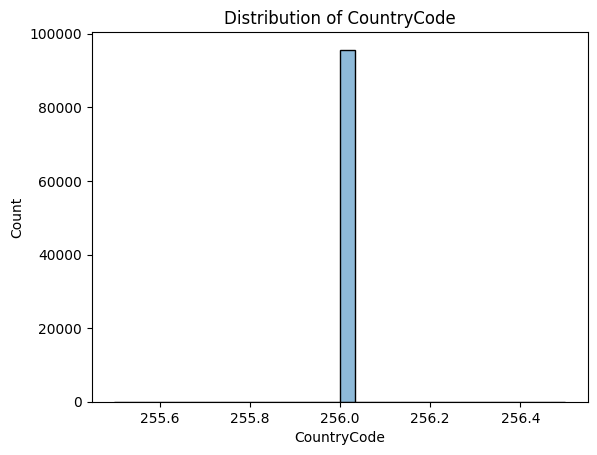

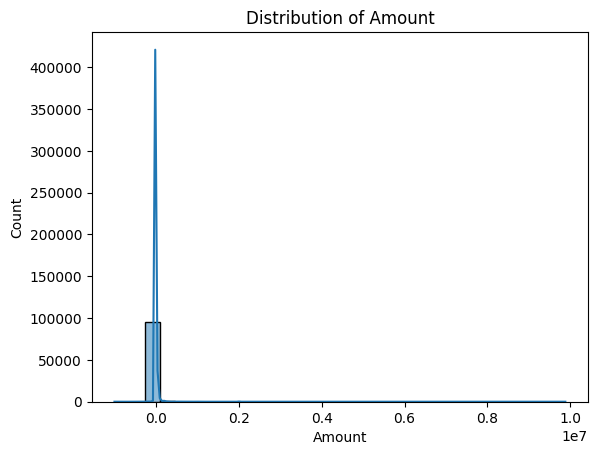

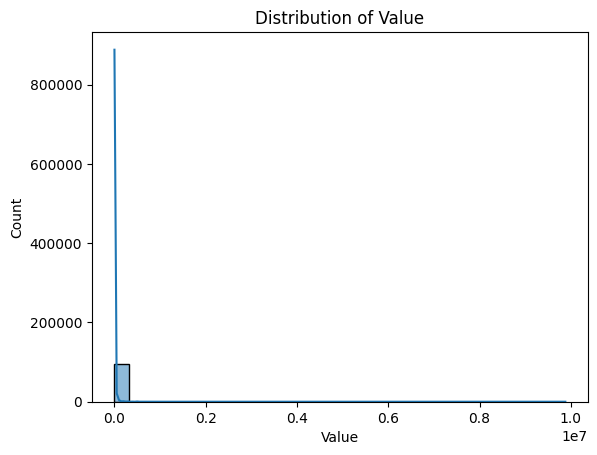

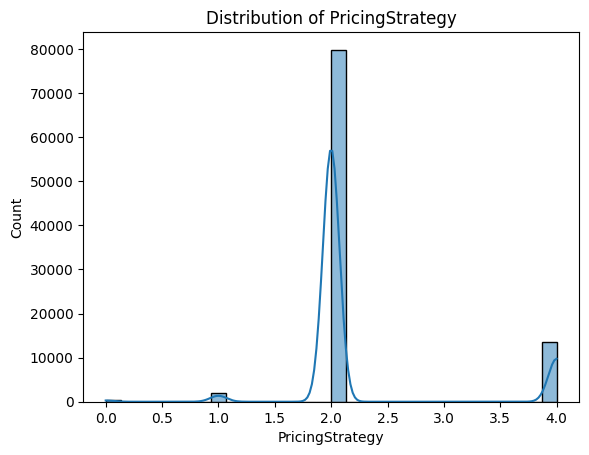

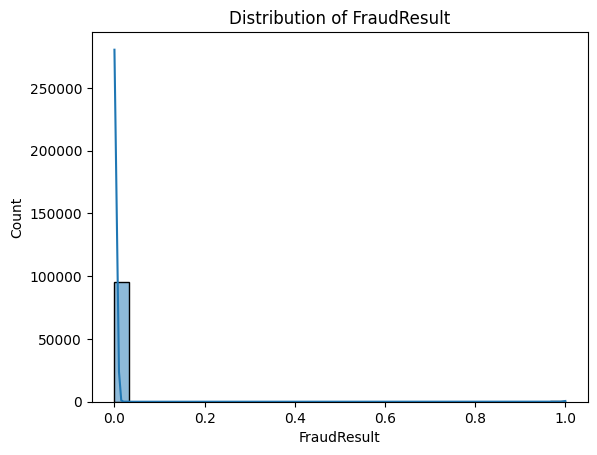

In [5]:
# Visualize distributions
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    plt.figure()
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

In [ ]:

# Correlation analysis
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [14]:

### Task 3: Feature Engineering
# Create aggregate features
customer_agg = data.groupby('CustomerId').agg({
    'Amount': ['sum', 'mean', 'std'],
    'TransactionId': 'count'
}).reset_index()
customer_agg.columns = ['CustomerId', 'TotalAmount', 'AvgAmount', 'StdDevAmount', 'TransactionCount']

# Time-based features
data['TransactionStartTime'] = pd.to_datetime(data['TransactionStartTime'])
data['TransactionHour'] = data['TransactionStartTime'].dt.hour
data['TransactionDay'] = data['TransactionStartTime'].dt.day
data['TransactionMonth'] = data['TransactionStartTime'].dt.month
data['TransactionYear'] = data['TransactionStartTime'].dt.year
data = data.drop(columns=['TransactionStartTime'])


# Categorical encoding
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

categorical_cols = ['ProductCategory', 'ChannelId']
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

In [ ]:


### Task 4: Default Estimator and WoE Binning
# Define high/low risk based on RFMS
rfms = data.groupby('CustomerId').agg({
    'TransactionStartTime': 'max',
    'TransactionId': 'count',
    'Amount': 'sum'
}).reset_index()
rfms.columns = ['CustomerId', 'Recency', 'Frequency', 'Monetary']

# Normalize RFMS
rfms['Recency'] = (rfms['Recency'] - rfms['Recency'].min()) / (rfms['Recency'].max() - rfms['Recency'].min())
rfms['Frequency'] = (rfms['Frequency'] - rfms['Frequency'].min()) / (rfms['Frequency'].max() - rfms['Frequency'].min())
rfms['Monetary'] = (rfms['Monetary'] - rfms['Monetary'].min()) / (rfms['Monetary'].max() - rfms['Monetary'].min())
rfms['Score'] = rfms[['Recency', 'Frequency', 'Monetary']].mean(axis=1)

# Define good/bad customers
rfms['Risk'] = np.where(rfms['Score'] >= 0.5, 0, 1)

In [9]:
### Task 5: Modeling
# Merge RFMS and original data
model_data = pd.merge(data, rfms[['CustomerId', 'Risk']], on='CustomerId')
X = model_data.drop(columns=['Risk', 'FraudResult'])
y = model_data['Risk']


In [16]:
# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create pipeline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42))
])




In [ ]:
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_


In [ ]:
# Evaluate model
from sklearn.metrics import classification_report, roc_auc_score

predictions = best_model.predict(X_test)
print(classification_report(y_test, predictions))
print("ROC-AUC:", roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]))

In [ ]:
# Save model
import pickle

with open('credit_scoring_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)


In [ ]:
### Task 6: Model Serving API
from flask import Flask, request, jsonify

app = Flask(__name__)

# Load model
with open('credit_scoring_model.pkl', 'rb') as f:
    model = pickle.load(f)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    features = np.array(data['features']).reshape(1, -1)
    prediction = model.predict_proba(features)[:, 1]
    return jsonify({'risk_score': prediction[0]})